In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
cell = 4
sno = 13
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [4]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0] = [1.2715e-07,1.2727e-06,1.1992,1.353e-9,0,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1] = [1.4819e-07,1.5114e-06,1.2484,1.4732e-09,0,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2] = [1.4493e-07,1.3608e-06,1.199,1.2138e-09,0,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3] = [1.043e-07,1.036e-06,1.208,1.6045e-09,0,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4] = [8.755e-08,8.572e-07,1.135,1.5788e-09,0,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5] = [8.7698e-08,8.5848e-07,1.1354,1.5778e-09,0,0]
# New Mech Damage Model
par_val[6] = [2.056E-07,2.4664E-06,1.2468,1.0482e-09,0,0]
# New Mech Damage Model with Lithium plating resistane
par_val[7] = [2.190e-07,2.308e-06,1.214,2.537e-09,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging
par_val[8] = [1.426e-07,3.832e-06,1.215,2.35e-09,1.462e-06,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 2
par_val[9] = [1.41036e-07,2.3913188000000003e-06,1.2098,2.4487124e-09,7.330208e-08,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 3
par_val[10] = [1.414e-07,1.5045e-06,1.2094,2.45e-09,4.603e-08,0]
# Post processing LAM model using simulated stress, tuned using C/5 and 1.5C Cycling aging 
par_val[11] = [4.2298e-08,3.1590e-07,1.0773,2.3688e-09,1.8939e-08,0]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging 
par_val[12] = [8.4600e-09,2.8926e-07,1.0462,2.8351e-09,7.6933e-11,0]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 2
par_val[13] = [4.0689e-08,2.8887e-07,1.0484,2.4848e-09,7.6548e-12,5.8577e-11]
# [8.5870e-09,2.8829e-07,1.0451,2.8285e-09,7.6933e-11]
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant proportional term 2 [s-1]": par_val[sno][5],
        "Negative electrode LAM constant proportional term 2 [s-1]": par_val[sno][4],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 4.544e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
        "Negative electrode critical stress [Pa]": 6e+07,
        "Positive electrode critical stress [Pa]": 375e+07,
    },
    check_already_exists=False,
)

In [29]:
1.1**1.2 

1.1211693641406024

In [28]:
0.3**1.2

0.23580092567898683

In [5]:
parameter_values.search("critical")

Negative electrode critical stress [Pa]	60000000.0
Positive electrode critical stress [Pa]	3750000000.0


In [6]:
c_rate_c ='C/5'
c_rate_d ='C/5'
# c_rate_c ='1.5C'
# c_rate_d ='1.5C'

In [7]:
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 10 sec",
         "Discharge at "+c_rate_d+" until 3V",
        #  "Discharge at "+c_rate_d+" for 150 min",
         )
    ]*1,
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)
SOC_0 =0.0

In [8]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

In [9]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries

    c_ss_n = solution["X-averaged negative particle surface concentration"].entries
    c_save_n1 = solution["R-averaged negative particle concentration"].entries
    c_save_n = c_save_n1[1,:]
    c_s_n = solution["X-averaged negative particle concentration"].entries

    c_ss_p = solution["X-averaged positive particle surface concentration"].entries
    c_save_p1 = solution["R-averaged positive particle concentration"].entries
    c_save_p = c_save_p1[1,:]
    c_s_p = solution["X-averaged positive particle concentration"].entries


    return t,V,I,Q,c_ss_n,c_save_n,c_s_n,c_ss_p,c_save_p,c_s_p

In [14]:
def graphite_volume_change(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    t_change = np.interp(x,stoichpoints,thicknesspoints)
    return t_change

In [15]:
def nmc_volume_change(sto):
        t_change = -1.10/100*(1-sto)
        return t_change

In [16]:
t,V,I,Q,c_ss_n,c_save_n,c_s_n,c_ss_p,c_save_p,c_s_p = plot_vars(solution1)

In [17]:
parameter_values.search("dis")

No results for search using 'dis'. Best matches are []


In [18]:
def sigma_hfun(c_s_n,c_s_p):

    Omega_n = param.n.Omega
    R_n = parameter_values.evaluate(param.n.prim.R_typ)
    E_n = param.n.E
    nu_n = param.n.nu
    CC_n = parameter_values.evaluate(2*E_n/(1-nu_n)/3)

    Omega_p = param.n.Omega
    R_p = parameter_values.evaluate(param.p.prim.R_typ)
    E_p = param.p.E
    nu_p = param.p.nu
    CC_p = parameter_values.evaluate(2*E_p/(1-nu_p)/3)

    Rvec_n = np.linspace(0,R_n,len(c_s_n))
    Rvec_p = np.linspace(0,R_p,len(c_s_p))
    sigma_h_n = []
    sigma_h_p = []
    for nn in range(np.size(c_s_n,1)):
        c_s_n1 = c_s_n[:,nn]
        y_s = np.vectorize(graphite_volume_change)(c_s_n1)
        cube_n = Rvec_n[1:]**3-Rvec_n[:-1]**3
        mul_n = (y_s[1:]+y_s[:-1])/2
        sigma_h_s_n = CC_n*((1/R_n**3)*1/3*np.sum(cube_n*mul_n)-1/3*y_s[-1])
        sigma_h_n.append(sigma_h_s_n)
        c_s_p1 = c_s_p[:,nn]
        x_s = np.vectorize(nmc_volume_change)(c_s_p1)
        cube_p = Rvec_p[1:]**3-Rvec_p[:-1]**3
        mul_p = (x_s[1:]+x_s[:-1])/2
        sigma_h_s_p = CC_p*((1/R_p**3)*1/3*np.sum(cube_p*mul_p)-1/3*x_s[-1])
        sigma_h_p.append(sigma_h_s_p)
    sigma_h_n = np.array(sigma_h_n)
    sigma_h_p = np.array(sigma_h_p)

    return sigma_h_n,sigma_h_p

In [19]:
sigma_h_n,sigma_h_p = sigma_hfun(c_s_n,c_s_p)

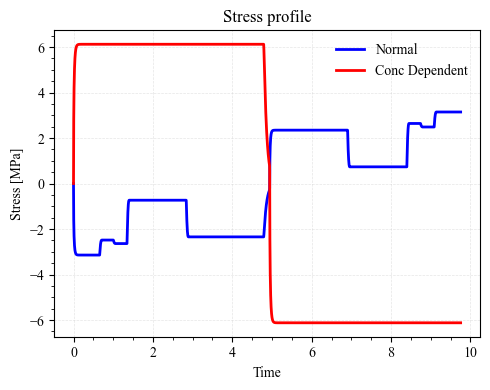

In [20]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t,sigma_h_n/1e6,'b')
ax1.plot(t,sigma_h_p/1e6,'r')
ax1.legend(["Normal","Conc Dependent","Simplified Conc Dep"])
ax1.set_title("Stress profile")
ax1.set_xlabel("Time")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
# plt.savefig(fig_DIR+'conc_dep_stress_cap_C5_100'+'.png')